# <center><ins>ML PROJECT</ins></center>

## <ins>Libraries</ins>

### Main Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk

### Data Visualization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

### Text Preprocessing

In [3]:
import neattext.functions as nfx
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [4]:
#nltk.download('wordnet') -> dependencies for nltk tokenization and lemmatization
#nltk.download('omw-1.4')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

### Pipelines

In [5]:
from sklearn.pipeline import Pipeline

### Vectorizers And Transformers

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### Algorithms And Ensembles

In [71]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier

### Split Data

In [8]:
from sklearn.model_selection import train_test_split

### Cross Validation

In [9]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score

### Metrics

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

### Parameter Tuning

In [42]:
from sklearn.model_selection import GridSearchCV

## <ins>Get Data</ins>

In [11]:
df = pd.read_csv('train.csv')

In [12]:
df.head()

,text,emotion
0,Yeah for coupons! Found this place randomly ...,neutral
1,i still love to feel a gentle breeze and hear ...,happiness
2,"Normal, fama devido ao programa de tv. A sobre...",neutral
3,im feeling a little less jaded,sadness
4,i have never shaken the feeling of ferocious p...,hate


## <ins>Data Exploration</ins>

In [13]:
df.shape

(8000, 2)

In [14]:
df.dtypes

text       object
emotion    object
dtype: object

In [15]:
df.isnull().sum()

text       0
emotion    0
dtype: int64

In [16]:
df.groupby(['emotion']).count()

,text
emotion,
fun,1157
happiness,1468
hate,1143
neutral,1292
sadness,1146
surprise,572
worry,1222


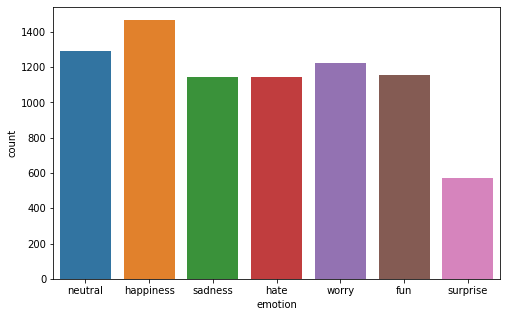

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x='emotion', data=df)
plt.show()

## <ins>Encode Label</ins>

In [18]:
def define_class(emotion):
    if emotion == 'sadness':
        return 0
    elif emotion == 'neutral':
        return 1
    elif emotion == 'worry':
        return 2
    elif emotion == 'happiness':
        return 3
    elif emotion == 'fun':
        return 4
    elif emotion == 'surprise':
        return 5
    elif emotion == 'hate':
        return 6
    else:
        raise Exception('Not a valid emotion')

In [19]:
df['emotion_class'] = df['emotion'].apply(define_class)

In [20]:
df.head()

,text,emotion,emotion_class
0,Yeah for coupons! Found this place randomly ...,neutral,1
1,i still love to feel a gentle breeze and hear ...,happiness,3
2,"Normal, fama devido ao programa de tv. A sobre...",neutral,1
3,im feeling a little less jaded,sadness,0
4,i have never shaken the feeling of ferocious p...,hate,6


In [21]:
df = df[['text','emotion_class']]

In [22]:
df.head()

,text,emotion_class
0,Yeah for coupons! Found this place randomly ...,1
1,i still love to feel a gentle breeze and hear ...,3
2,"Normal, fama devido ao programa de tv. A sobre...",1
3,im feeling a little less jaded,0
4,i have never shaken the feeling of ferocious p...,6


## <ins>Preprocess Text</ins>

In [23]:
df['new_text'] = df['text'].apply(lambda x: x.lower())
df['new_text'] = df['new_text'].apply(nfx.remove_multiple_spaces)
df['new_text'] = df['new_text'].apply(nfx.remove_punctuations)
df['new_text'] = df['new_text'].apply(nfx.remove_puncts)
df['new_text'] = df['new_text'].apply(nfx.remove_stopwords)
df['new_text'] = df['new_text'].apply(nfx.remove_emojis)
df['new_text'] = df['new_text'].apply(nfx.remove_special_characters)
df['new_text'] = df['new_text'].apply(nfx.remove_bad_quotes)
df['new_text'] = df['new_text'].apply(nfx.remove_non_ascii)
df['new_text'] = df['new_text'].apply(nfx.remove_accents)
df['new_text'] = df['new_text'].apply(nfx.remove_urls)
df['new_text'] = df['new_text'].apply(nfx.remove_html_tags)
df['new_text'] = df['new_text'].apply(nfx.remove_userhandles)
df['new_text'] = df['new_text'].apply(nfx.remove_hashtags)
df['new_text'] = df['new_text'].apply(nfx.remove_phone_numbers)

In [24]:
df.head()

,text,emotion_class,new_text
0,Yeah for coupons! Found this place randomly ...,1,yeah coupons found place randomly like lot dif...
1,i still love to feel a gentle breeze and hear ...,3,love feel gentle breeze hear peal soft wind ch...
2,"Normal, fama devido ao programa de tv. A sobre...",1,normal fama devido ao programa de tv sobremesa...
3,im feeling a little less jaded,0,im feeling little jaded
4,i have never shaken the feeling of ferocious p...,6,shaken feeling ferocious protectiveness mother


In [25]:
df = df[['new_text','emotion_class']]

In [26]:
df.head()

,new_text,emotion_class
0,yeah coupons found place randomly like lot dif...,1
1,love feel gentle breeze hear peal soft wind ch...,3
2,normal fama devido ao programa de tv sobremesa...,1
3,im feeling little jaded,0
4,shaken feeling ferocious protectiveness mother,6


## <ins>Setup Tokenization And Lemmatization Parameter</ins>

In [27]:
# Lemmatization is slower than stemming but it is generally more effective. It gives more context and meaning to words. It preserves them
class LemmaTokenizer:
    def __init__(self):
        self.lemma = WordNetLemmatizer()
    def __call__(self, text):
        tokenized = word_tokenize(text)
        lemmatized=[]
        
        for token,tag in pos_tag(tokenized):
            pos=tag[0].lower()
        
            if pos not in ['a', 'r', 'n', 'v']:
                pos='n'
            
            lemmatized.append(self.lemma.lemmatize(token,pos))    
        
        return lemmatized

## <ins>Setup Folds With StratifiedKFold</ins>

In [28]:
folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1000) # since dataset is somewhat imbalanced (1 class)

## <ins> Base Models With Estimators And Transformers</ins>

In [29]:
target_names = ['sadness','neutral','worry','happiness','fun','surprise','hate']

### SVM

In [30]:
svm = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(decision_function_shape='ovr')),
])

svm_prediction = cross_val_predict(svm, df['new_text'], df['emotion_class'], cv = folds)
svm_score = cross_val_score(svm, df['new_text'], df['emotion_class'], cv = folds)

svm_report = classification_report(df['emotion_class'], svm_prediction, target_names=target_names, output_dict=True)

<AxesSubplot:title={'center':'SVM Metrics'}>

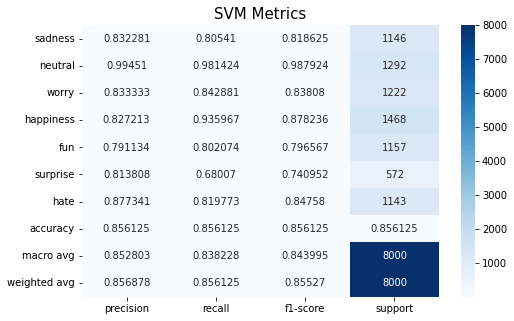

In [31]:
plt.figure(figsize=(8, 5))
plt.title('SVM Metrics', fontsize=15)
sns.heatmap(pd.DataFrame(svm_report).T, annot=True, cmap='Blues', fmt='g')

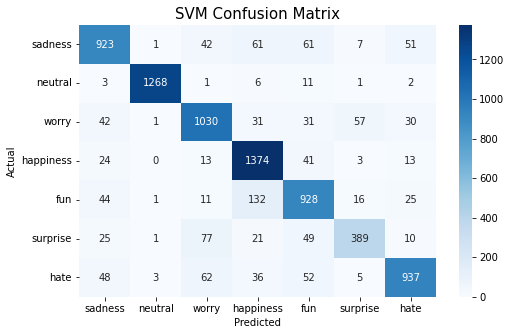

In [32]:
svm_matrix = confusion_matrix(df['emotion_class'], svm_prediction)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(svm_matrix, target_names, target_names), annot=True, cmap='Blues', fmt='g')
plt.title('SVM Confusion Matrix', fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<AxesSubplot:title={'center':'SVM Fold Scores Boxplot'}>

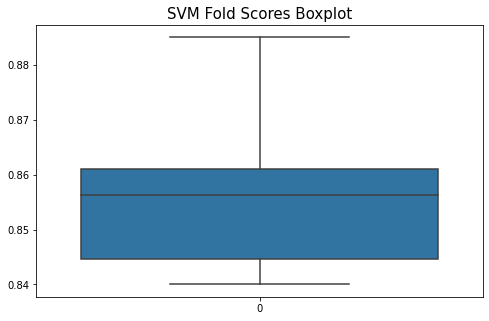

In [33]:
plt.figure(figsize=(8, 5))
plt.title('SVM Fold Scores Boxplot', fontsize=15)
sns.boxplot(data=svm_score)

### SGD

In [34]:
sgd = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer()),
    ('sgd', OneVsRestClassifier(SGDClassifier())),
])

sgd_prediction = cross_val_predict(sgd, df['new_text'], df['emotion_class'], cv = folds)
sgd_score = cross_val_score(sgd, df['new_text'], df['emotion_class'], cv = folds)

sgd_report = classification_report(df['emotion_class'], sgd_prediction, target_names=target_names, output_dict=True)

<AxesSubplot:title={'center':'SGD Metrics'}>

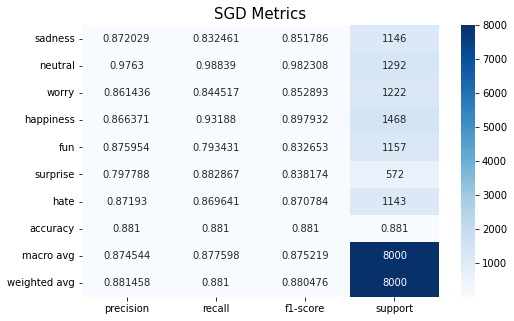

In [35]:
plt.figure(figsize=(8, 5))
plt.title('SGD Metrics', fontsize=15)
sns.heatmap(pd.DataFrame(sgd_report).T, annot=True, cmap='Blues', fmt='g')

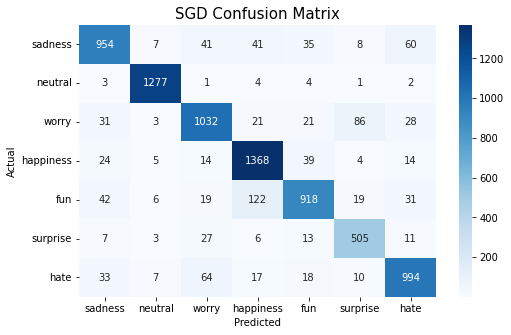

In [36]:
sgd_matrix = confusion_matrix(df['emotion_class'], sgd_prediction)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(sgd_matrix, target_names, target_names), annot=True, cmap='Blues', fmt='g')
plt.title('SGD Confusion Matrix', fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<AxesSubplot:title={'center':'SGD Fold Scores Boxplot'}>

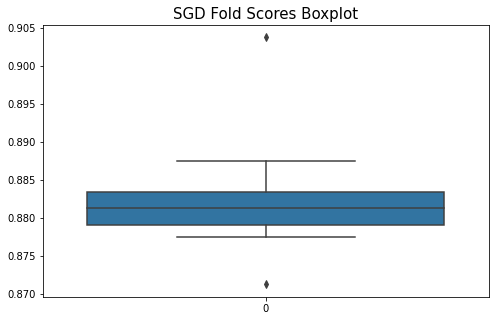

In [37]:
plt.figure(figsize=(8, 5))
plt.title('SGD Fold Scores Boxplot', fontsize=15)
sns.boxplot(data=sgd_score)

### Naive Bayes (Multinomial)

In [38]:
bayes = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer()),
    ('bayes', OneVsRestClassifier(MultinomialNB())),
])

bayes_prediction = cross_val_predict(bayes, df['new_text'], df['emotion_class'], cv = folds)
bayes_score = cross_val_score(bayes, df['new_text'], df['emotion_class'], cv = folds)

bayes_report = classification_report(df['emotion_class'], bayes_prediction,target_names=target_names, output_dict=True)

<AxesSubplot:title={'center':'MultinomialNB Metrics'}>

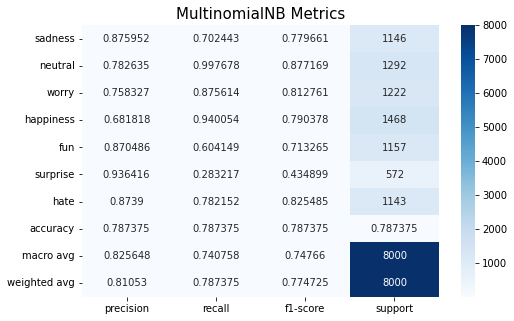

In [61]:
plt.figure(figsize=(8, 5))
plt.title('MultinomialNB Metrics', fontsize=15)
sns.heatmap(pd.DataFrame(bayes_report).T, annot=True, cmap='Blues', fmt='g')

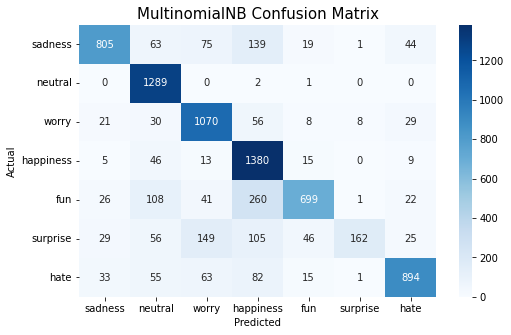

In [60]:
bayes_matrix = confusion_matrix(df['emotion_class'], bayes_prediction)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(bayes_matrix, target_names, target_names), annot=True, cmap='Blues', fmt='g')
plt.title('MultinomialNB Confusion Matrix', fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<AxesSubplot:title={'center':'MultinomialNB Fold Scores Boxplot'}>

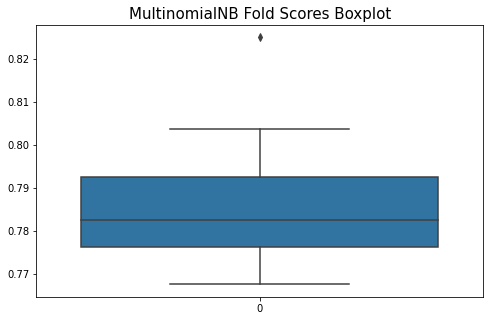

In [41]:
plt.figure(figsize=(8, 5))
plt.title('MultinomialNB Fold Scores Boxplot', fontsize=15)
sns.boxplot(data=bayes_score)

## <ins>Parameter Tuning (GridSearchCV)</ins>

### Train Test Split

In [70]:
x_train, x_test, y_train, y_test = train_test_split(df['new_text'],df['emotion_class'],shuffle=True,stratify=df['emotion_class'],test_size=0.2,random_state=20)

### Pipelines

In [45]:
pipe_svm = Pipeline([('vect', CountVectorizer(tokenizer=LemmaTokenizer())),('transformer', TfidfTransformer()),('svm', SVC(decision_function_shape='ovr'))])
pipe_sgd = Pipeline([('vect', CountVectorizer(tokenizer=LemmaTokenizer())),('transformer', TfidfTransformer()),('sgd', OneVsRestClassifier(SGDClassifier()))])
pipe_bayes = Pipeline([('vect', CountVectorizer(tokenizer=LemmaTokenizer())),('transformer', TfidfTransformer()),('mnb', OneVsRestClassifier(MultinomialNB()))])

### Parameters

In [ ]:
# Support Vector Machine parameters to test
svm_params = {'svm__C': [0.1, 1, 10, 100, 1000],
              'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svm__kernel': ('linear','rbf'),
              'vect__ngram_range': [(1, 1), (1, 2)]
             }

# SGD Classifier parameters to test
sgd_params = {
    "sgd__loss" : ["hinge", "log_loss", "squared_hinge", "modified_huber"],
    "sgd__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "sgd__penalty" : ["l2", "l1", "none"],
    "sgd__learning_rate" : ["constant","optimal","invscaling","adaptive"],
    "sgd__class_weight": [None,'balanced'],
    'vect__ngram_range': [(1, 1), (1, 2)],
             }

# Bayes Classifier parameters to test
bayes_params = {
    "mnb__alpha" : [0.01, 0.1, 0.5, 1.0, 10.0],
    "mnb__fit_prior" : (True,False),
    "vect__ngram_range":[(1,1),(1,2),(1,6)]
               }

### Process

In [ ]:
# Setting up grids
grid_svm = GridSearchCV(pipe_svm, parameters, refit = True, verbose = 3)
grid_sgd = GridSearchCV(pipe_sgd, parameters, refit = True, verbose = 3)
grid_bayes = GridSearchCV(pipe_bayes, parameters, refit = True, verbose = 3)

# Fitting the grid
grid.fit(x_train, y_train)
grid.fit(x_train, y_train)
grid.fit(x_train, y_train)

### Results

In [54]:
# Support Vector Machine
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'linear', 'vect__ngram_range': (1, 2)}

{'svc__C': 1,
 'svc__gamma': 1,
 'svc__kernel': 'linear',
 'vect__ngram_range': (1, 2)}

In [50]:
# SGD Classifier
{'sgd__loss': 'hinge', 'sgd__alpha': '0.0001', 'sgd__penalty': 'l1', 'sgd__learning_rate': 'optimal', 'sgd__class_weight': None, 'vect__ngram_range': (1,2)}

{'sgd__loss': 'hinge',
 'sgd__alpha': '0.0001',
 'sgd__penalty': 'l1',
 'sgd__learning_rate': 'optimal',
 'sgd__class_weight': None,
 'vect__ngram_range': (1, 2)}

In [59]:
# Bayes Classifier
{'mb__alpha': 0.1, 'mb__fit_prior': False, 'vect__ngram_range': (1,6)}

{'mb__alpha': 0.1, 'mb__fit_prior': False, 'vect__ngram_range': (1, 6)}

## <ins>After Tuning</ins>

### SVM

In [55]:
svm_after = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(C=1,gamma=1,kernel='linear',decision_function_shape='ovr')),
])

svm_prediction_after = cross_val_predict(svm_after, df['new_text'], df['emotion_class'], cv = folds)
svm_score_after = cross_val_score(svm_after, df['new_text'], df['emotion_class'], cv = folds)

svm_report_after = classification_report(df['emotion_class'], svm_prediction_after, target_names=target_names, output_dict=True)

<AxesSubplot:title={'center':'SVM Metrics After'}>

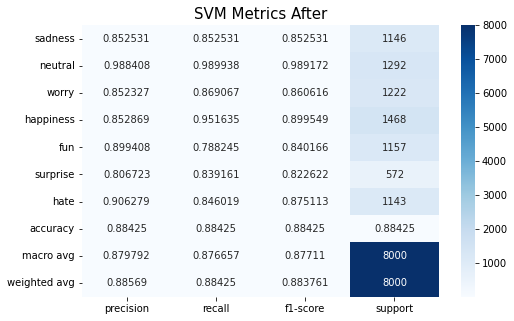

In [56]:
plt.figure(figsize=(8, 5))
plt.title('SVM Metrics After', fontsize=15)
sns.heatmap(pd.DataFrame(svm_report_after).T, annot=True, cmap='Blues', fmt='g')

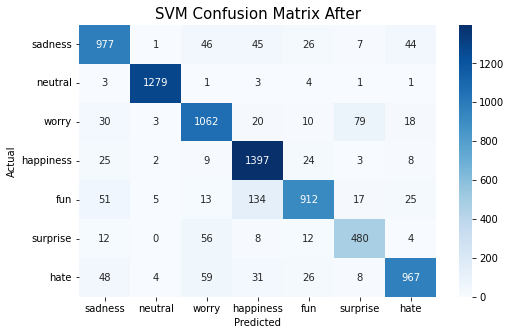

In [57]:
svm_matrix_after = confusion_matrix(df['emotion_class'], svm_prediction_after)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(svm_matrix_after, target_names, target_names), annot=True, cmap='Blues', fmt='g')
plt.title('SVM Confusion Matrix After', fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<AxesSubplot:title={'center':'SVM Fold Scores Boxplot After'}>

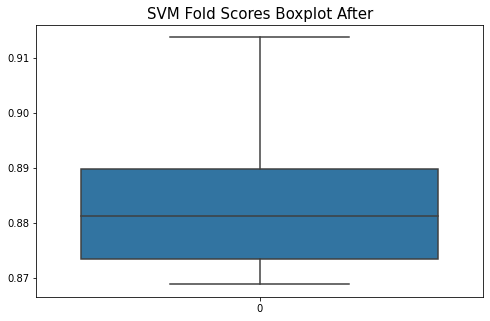

In [58]:
plt.figure(figsize=(8, 5))
plt.title('SVM Fold Scores Boxplot After', fontsize=15)
sns.boxplot(data=svm_score_after)

### SGD

In [62]:
sgd_after = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('sgd', OneVsRestClassifier(SGDClassifier(loss='hinge',alpha=0.0001,penalty='l1',learning_rate='optimal',class_weight=None))),
])

sgd_prediction_after = cross_val_predict(sgd_after, df['new_text'], df['emotion_class'], cv = folds)
sgd_score_after = cross_val_score(sgd_after, df['new_text'], df['emotion_class'], cv = folds)

sgd_report_after = classification_report(df['emotion_class'], sgd_prediction_after, target_names=target_names, output_dict=True)

<AxesSubplot:title={'center':'SGD Metrics After'}>

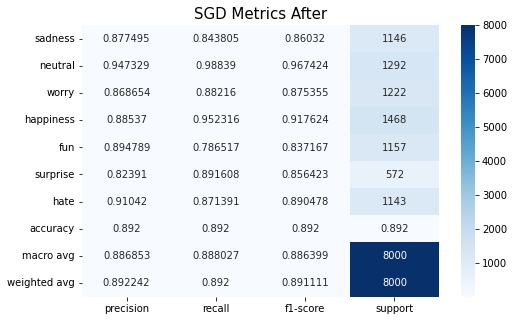

In [63]:
plt.figure(figsize=(8, 5))
plt.title('SGD Metrics After', fontsize=15)
sns.heatmap(pd.DataFrame(sgd_report_after).T, annot=True, cmap='Blues', fmt='g')

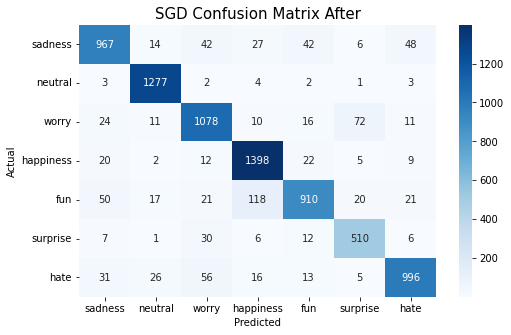

In [64]:
sgd_matrix_after = confusion_matrix(df['emotion_class'], sgd_prediction_after)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(sgd_matrix_after, target_names, target_names), annot=True, cmap='Blues', fmt='g')
plt.title('SGD Confusion Matrix After', fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<AxesSubplot:title={'center':'SGD Fold Scores Boxplot After'}>

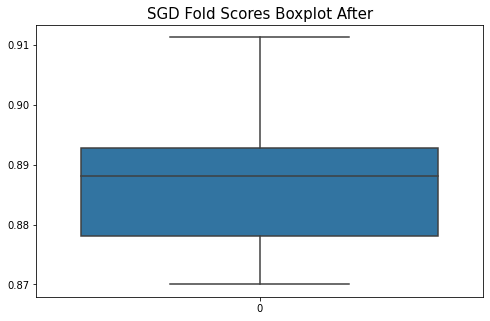

In [65]:
plt.figure(figsize=(8, 5))
plt.title('SGD Fold Scores Boxplot After', fontsize=15)
sns.boxplot(data=sgd_score_after)

### Naive Bayes (Multinomial)

In [66]:
mnb_after = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(1,6))),
    ('tfidf', TfidfTransformer()),
    ('mnb', OneVsRestClassifier(MultinomialNB(alpha=0.1,fit_prior=False))),
])

mnb_prediction_after = cross_val_predict(mnb_after, df['new_text'], df['emotion_class'], cv = folds)
mnb_score_after = cross_val_score(mnb_after, df['new_text'], df['emotion_class'], cv = folds)

mnb_report_after = classification_report(df['emotion_class'], mnb_prediction_after, target_names=target_names, output_dict=True)

<AxesSubplot:title={'center':'MultinomialNB Metrics After'}>

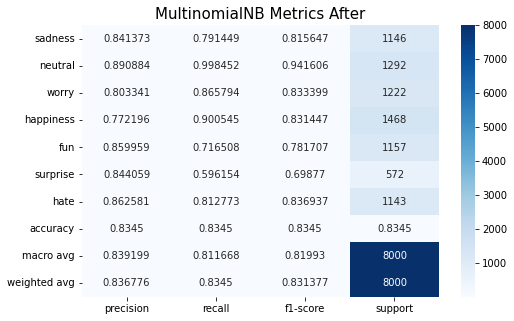

In [67]:
plt.figure(figsize=(8, 5))
plt.title('MultinomialNB Metrics After', fontsize=15)
sns.heatmap(pd.DataFrame(mnb_report_after).T, annot=True, cmap='Blues', fmt='g')

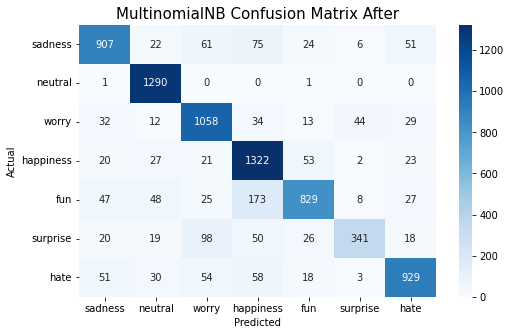

In [68]:
mnb_matrix_after = confusion_matrix(df['emotion_class'], mnb_prediction_after)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(mnb_matrix_after, target_names, target_names), annot=True, cmap='Blues', fmt='g')
plt.title('MultinomialNB Confusion Matrix After', fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<AxesSubplot:title={'center':'MultinomialNB Fold Scores Boxplot After'}>

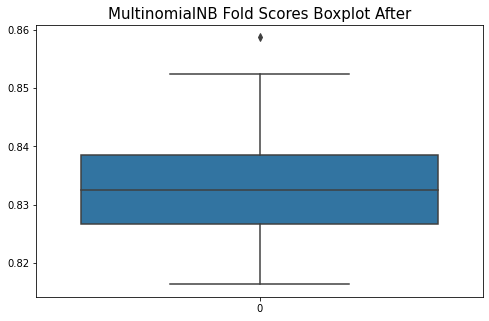

In [69]:
plt.figure(figsize=(8, 5))
plt.title('MultinomialNB Fold Scores Boxplot After', fontsize=15)
sns.boxplot(data=mnb_score_after)

## <ins>Winner</ins>

And the winner is...<b>SGDClassifier</b>

## <ins>Stacking</ins>

In [89]:
estimators = [('svc',SVC(C=1,gamma=1,kernel='linear',decision_function_shape='ovr'))]

In [90]:
final_estimator = OneVsRestClassifier(SGDClassifier(loss='hinge',alpha=0.0001,penalty='l1',learning_rate='optimal',class_weight=None))

In [91]:
stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=10)

In [92]:
stacking_pipe = Pipeline([('vect', CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(1,2))),('tfidf', TfidfTransformer()),('stack', stack)])

In [93]:
stacking_pipe.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2),
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000206A7911708>)),
                ('tfidf', TfidfTransformer()),
                ('stack',
                 StackingClassifier(cv=10,
                                    estimators=[('svc',
                                                 SVC(C=1, gamma=1,
                                                     kernel='linear'))],
                                    final_estimator=OneVsRestClassifier(estimator=SGDClassifier(penalty='l1'))))])

In [94]:
stacking_pipe.score(x_test,y_test)

0.88875

In [95]:
stacking_pipe.score(x_train,y_train)

0.99

## <ins>Results</ins>

<b>SGDClassifier</b> alone still wins